In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from env import host, user, password

In [2]:
def get_connection(db, user=user, host=host,password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def wrangle_zillow():
    filename = 'zillow_values.csv'
    # Acquire data from csv if exists
    if os.path.exists(filename):
        print ('Using cached csv')
        return pd.read_csv(filename, index_col=0)
    # Acquire data from database if no CSV exists
    else:
        query = '''
            SELECT parcelid AS parcel,
            bedroomcnt AS bedrooms,
            bathroomcnt AS bathrooms,
            calculatedfinishedsquarefeet AS square_feet,
            taxvaluedollarcnt AS tax_value,
            yearbuilt AS year,
            taxamount AS tax_amount,
            fips as fed_code
            FROM properties_2017
            JOIN predictions_2017 USING (parcelid)
            JOIN propertylandusetype USING (propertylandusetypeid)
            WHERE transactiondate IS NOT NULL
            AND propertylandusedesc IN("Single Family Residential","Inferred Single Family Residential")
            AND transactiondate BETWEEN '2017-01-01' and '2017-12-31'
            '''
        df = pd.read_sql(query, get_connection('zillow'))
        df.to_csv('zillow_values.csv', index = False)
    
    return df


In [3]:
# Original query had 2M rows, limited rows by selecting transaction date in 2017
df = wrangle_zillow()

Using cached csv


In [4]:
# Reset index to get parcel as column
df=df.reset_index()

In [5]:
df.shape

(52441, 8)

In [6]:
df.head()

,parcel,bedrooms,bathrooms,square_feet,tax_value,year,tax_amount,fed_code
0,14297519,4.0,3.5,3100.0,1023282.0,1998.0,11013.72,6059.0
1,17052889,2.0,1.0,1465.0,464000.0,1967.0,5672.48,6111.0
2,14186244,3.0,2.0,1243.0,564778.0,1962.0,6488.30,6059.0
3,12177905,4.0,3.0,2376.0,145143.0,1970.0,1777.51,6037.0
4,12095076,4.0,3.0,2962.0,773303.0,1950.0,9516.26,6037.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   parcel       52441 non-null  int64  
 1   bedrooms     52441 non-null  float64
 2   bathrooms    52441 non-null  float64
 3   square_feet  52359 non-null  float64
 4   tax_value    52440 non-null  float64
 5   year         52325 non-null  float64
 6   tax_amount   52437 non-null  float64
 7   fed_code     52441 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.2 MB


In [8]:
# should be int for bed,bath, Year
# Will change in wrangle.py

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
parcel,52441.0,1.299912e+07,3.411444e+06,10711855.00,11510217.00,12577645.00,14129530.00,167687839.0
bedrooms,52441.0,3.300681e+00,9.490939e-01,0.00,3.00,3.00,4.00,14.0
bathrooms,52441.0,2.299403e+00,1.022772e+00,0.00,2.00,2.00,3.00,18.0
square_feet,52359.0,1.922891e+03,1.004366e+03,128.00,1268.00,1659.00,2306.00,21929.0
tax_value,52440.0,5.296882e+05,7.518946e+05,1000.00,193747.50,373612.00,619301.25,49061236.0
year,52325.0,1.963394e+03,2.313357e+01,1878.00,1950.00,1961.00,1979.00,2016.0
tax_amount,52437.0,6.453511e+03,8.755568e+03,49.18,2656.22,4647.74,7377.50,586639.3
fed_code,52441.0,6.049132e+03,2.102907e+01,6037.00,6037.00,6037.00,6059.00,6111.0


In [10]:
df.isna().sum()

parcel           0
bedrooms         0
bathrooms        0
square_feet     82
tax_value        1
year           116
tax_amount       4
fed_code         0
dtype: int64

In [11]:
# Low number of missing values

*** Acquire and Summarize Takeaways ***
- small number of na values - could drop 
- Need to change float to int64 for year, bedrooms, bathrooms, fed_code
- may want to add columns to query
    - garage (null would be zero filled)
    - pool (null would be zero filled)
    - year assessed
    - zip code of property (to know location)
    - Air conditioning (correlation to location)
    

## Prepare the Data

In [12]:
df.isnull().sum()

parcel           0
bedrooms         0
bathrooms        0
square_feet     82
tax_value        1
year           116
tax_amount       4
fed_code         0
dtype: int64

In [38]:
df.year.value_counts()

1955.0    1898
1950.0    1608
1954.0    1517
1953.0    1484
1956.0    1387
          ... 
1892.0       1
1878.0       1
1882.0       1
1894.0       1
1880.0       1
Name: year, Length: 133, dtype: int64

In [13]:
df.columns[df.isnull().any()]

Index(['square_feet', 'tax_value', 'year', 'tax_amount'], dtype='object')

In [24]:
# Dropping na values 
#(may want to be cautious if pulling in pool or garage data as these will have multiple null values)
df=df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52315 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   parcel       52315 non-null  int64  
 1   bedrooms     52315 non-null  float64
 2   bathrooms    52315 non-null  float64
 3   square_feet  52315 non-null  float64
 4   tax_value    52315 non-null  float64
 5   year         52315 non-null  float64
 6   tax_amount   52315 non-null  float64
 7   fed_code     52315 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.6 MB


In [15]:
# Replace a whitespace sequence or empty with a NaN value and reassign this manipulation to df.

df = df.replace(r'^\s*$', np.nan, regex=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52315 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   parcel       52315 non-null  int64  
 1   bedrooms     52315 non-null  float64
 2   bathrooms    52315 non-null  float64
 3   square_feet  52315 non-null  float64
 4   tax_value    52315 non-null  float64
 5   year         52315 non-null  float64
 6   tax_amount   52315 non-null  float64
 7   fed_code     52315 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.6 MB


In [18]:
# Not finding other values... why non_null values are not equal among data
df.columns

Index(['parcel', 'bedrooms', 'bathrooms', 'square_feet', 'tax_value', 'year',
       'tax_amount', 'fed_code'],
      dtype='object')

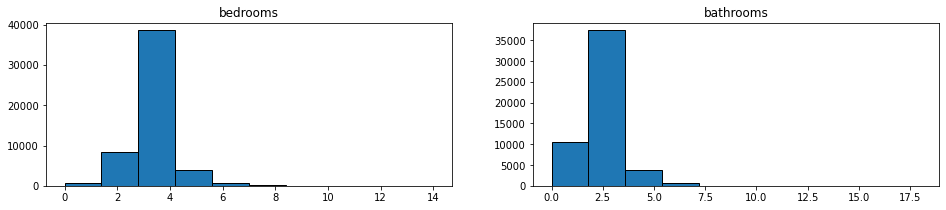

In [23]:
plt.figure(figsize = (16,3))

# list of Columns
cols = ['bedrooms', 'bathrooms']

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,2, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    df[col].hist(bins=10, edgecolor='black')
    
    # Hide gridlines.
    plt.grid(False)
        

Text(0.5, 1.0, 'Tax value capped $1000000')

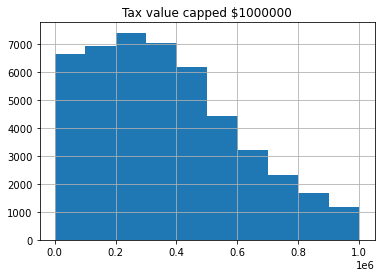

In [31]:

cap = 1000000
(df.tax_value>cap).sum()
df[df.tax_value<cap].tax_value.hist()
plt.title(f'Tax value capped ${cap}')

Text(0.5, 1.0, 'Tax amount capped 50000')

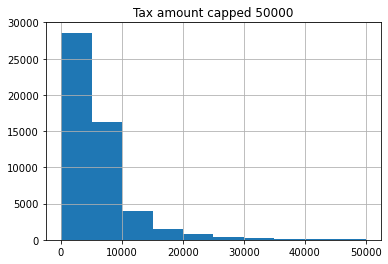

In [32]:
cap = 50000
(df.tax_amount>cap).sum()
df[df.tax_amount<cap].tax_amount.hist()
plt.title(f'Tax amount capped {cap}')

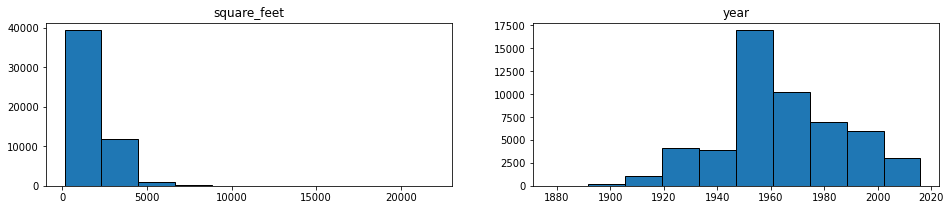

In [21]:
plt.figure(figsize = (16,3))

# list of Columns
cols = ['square_feet', 'year']

for i, col in enumerate(cols):
    
    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 
    
    # Create subplot.
    plt.subplot(1,2, plot_number)
    
    # Title with column name.
    plt.title(col)
    
    # Display histogram for column.
    df[col].hist(bins=10, edgecolor='black')
    
    # Hide gridlines.
    plt.grid(False)

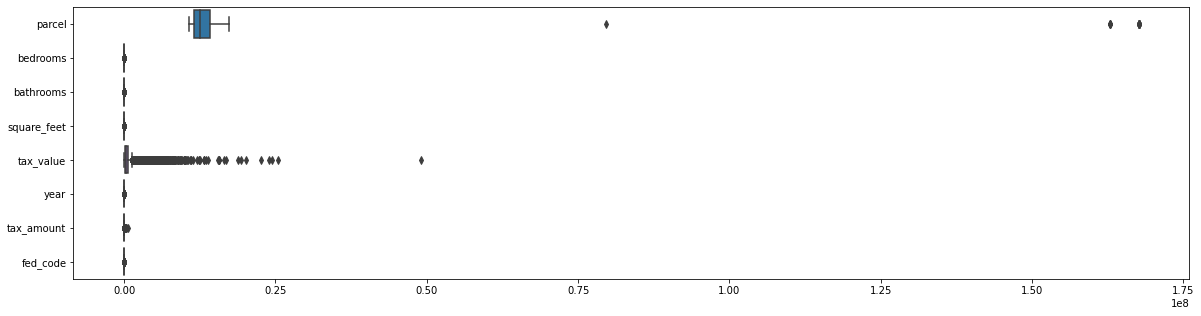

In [35]:
plt.figure(figsize=(20,5))
ax = sns.boxplot(data=df, orient='h')
plt.show()

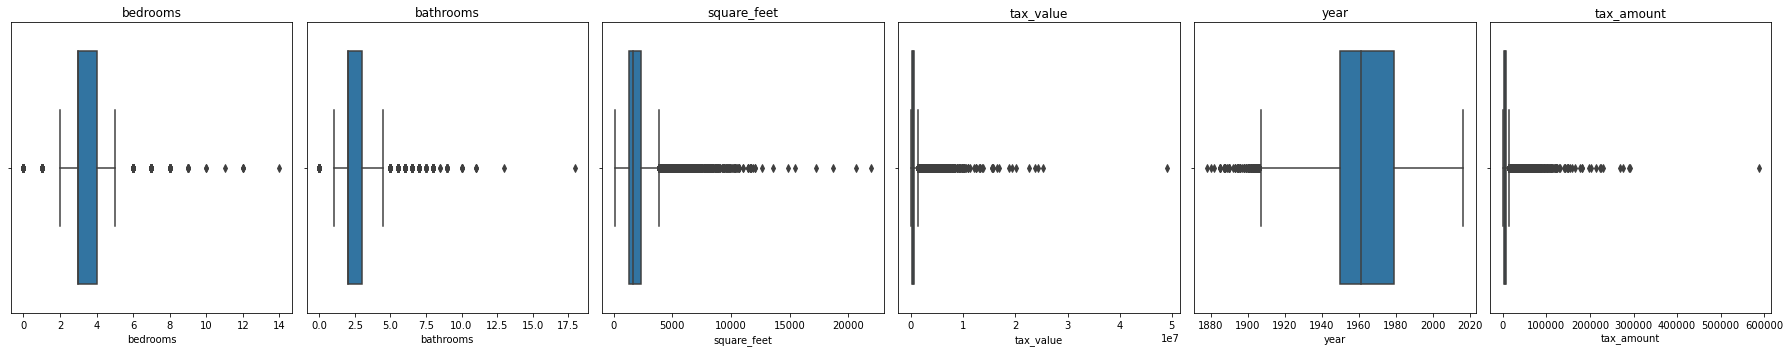

In [36]:
# Visualize Boxplot/Skew


# list of numeric columns
cols = [col for col in df.columns if col not in ['fed_code', 'parcel']]

# figsize width to height
plt.figure(figsize=(25, 5))

# loop to iterate over columns
for i, col in enumerate(cols):
        
        # i starts at 0 but plot numbers should start at 1
        plot_number = i + 1
        
        # create subplot
        plt.subplot(1, len(cols), plot_number)
        
        # create title with the column name
        plt.title(col)
        
        # display a histogram for each of the columns            
        sns.boxplot(df[col])
        
        # Hide gridlines.
        plt.grid(False)
         
      
    
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Square feet distribution for those under 5000 sq ft: Fairly normal ')

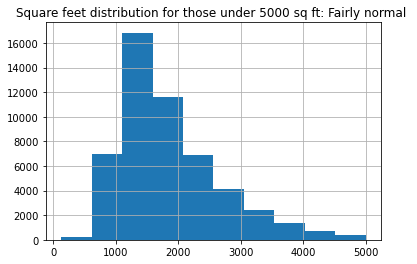

In [37]:
threshold = 5000
df[df.square_feet<threshold].square_feet.hist()
plt.title(f"Square feet distribution for those under {threshold} sq ft: Fairly normal ")

*** Takeaway ***

- Possible outliers in data based on tax value/amount
- May want to assess if properties built prior to 1900 are worth excluding
- Possible outliers with beds/baths
- Possible sq ft threshold min for consideration?